In [1]:
from warnings import filterwarnings
filterwarnings(action='ignore')

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import pickle

### Load data

In [2]:
df = pd.read_csv("./dataset_iris.csv")

In [3]:
df.head(4)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa


In [4]:
print(f"Dataset have {df.shape[0]} rows and {df.shape[1]} columns")

Dataset have 150 rows and 5 columns


### Let's check for na values

In [5]:
df.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

###### There is no null values in dataset 

### Datasets Distribution according to species

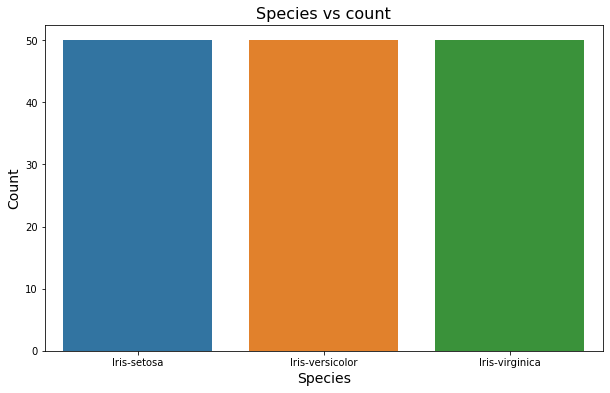

In [6]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="species", data=df)

plt.xlabel("Species", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Species vs count", fontsize=16)
plt.show()

In [7]:
def get_target(val):
    res = ''
    if val == 'Iris-setosa':
        res = 1
    elif val == 'Iris-versicolor':
        res = 2
    elif val == 'Iris-virginica':
        res = 3
    return res


df['target'] = df['species'].apply(get_target)

In [8]:
df.head(2)

,sepal_length,sepal_width,petal_length,petal_width,species,target
0,5.1,3.5,1.4,0.2,Iris-setosa,1
1,4.9,3.0,1.4,0.2,Iris-setosa,1


### Distribution of Features

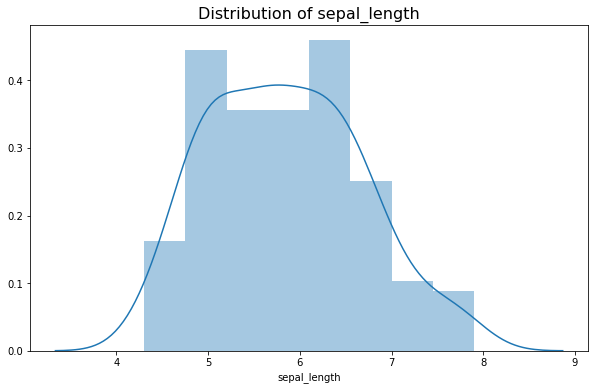

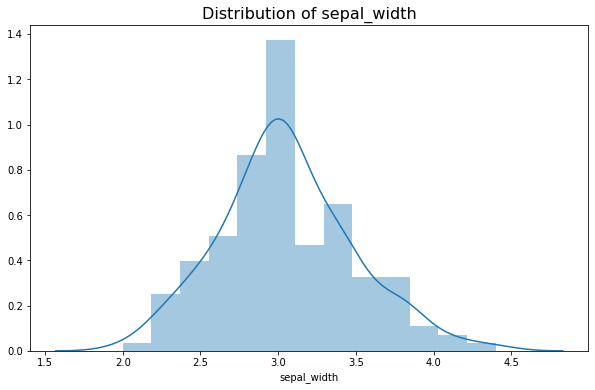

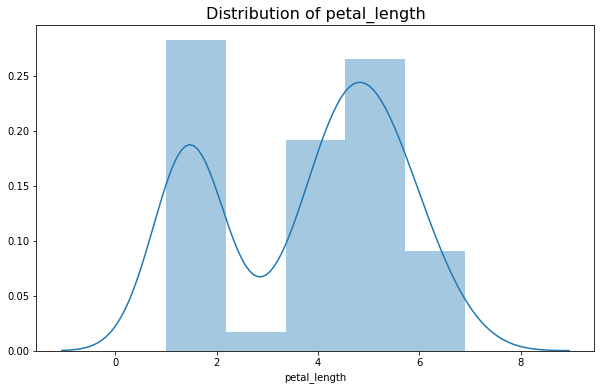

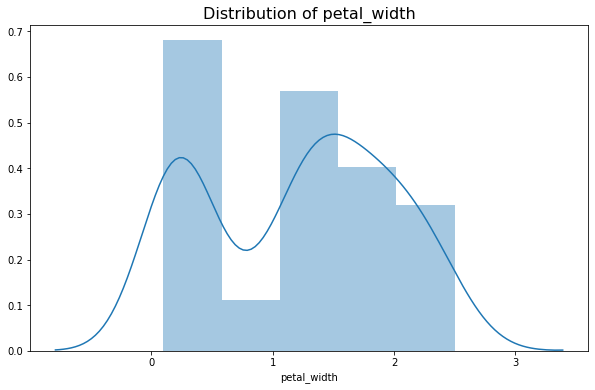

In [9]:
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

for col in features:
    plt.figure(figsize=(10, 6))
    sns.distplot(df[col])
    plt.title("Distribution of "+col, fontsize=16)
    plt.show()

### Correlation plot

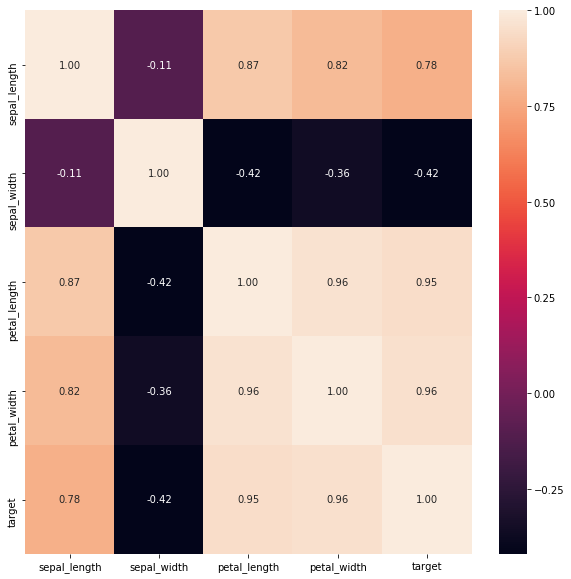

In [10]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.drop(columns=['species']).corr(), fmt='.2f', annot=True)

plt.show()

### separate features, target

In [11]:
X, y = df.drop(columns=['species', 'target']), df['species']

### Create Train, test data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y)

### Scale data

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

### Encode labels

In [14]:
label_enc = LabelEncoder()
label_enc.fit(y_train)

y_train = label_enc.transform(y_train)
y_test = label_enc.transform(y_test)

### Create function for cross-validation

In [15]:
def cvs(clf, name, c=5):
    res =  cross_val_score(clf, X, y, cv=c)
    _data = {}
    _data['algo'] = name
    _data['mean'] = res.mean()
    _data['std'] = res.std()
    return _data

In [16]:
scores = []

lr = LogisticRegression()
knn = KNeighborsClassifier()
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()
rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
etc = ExtraTreesClassifier()
xgb = XGBClassifier()
lgc = LGBMClassifier()

scores.append(cvs(lr, 'lr'))
scores.append(cvs(knn, 'knn'))
scores.append(cvs(gnb, 'gnb'))
scores.append(cvs(bnb, 'bnb'))
scores.append(cvs(mnb, 'mnb'))
scores.append(cvs(rfc, 'rfc'))
scores.append(cvs(abc, 'abc'))
scores.append(cvs(etc, 'etc'))
scores.append(cvs(xgb, 'xgb'))
scores.append(cvs(lgc, 'lgc'))

In [17]:
df_algo = pd.DataFrame.from_records(scores)
df_algo = df_algo.sort_values(by=['std'])

print(df_algo)

  algo      mean       std
3  bnb  0.333333  0.000000
5  rfc  0.966667  0.021082
7  etc  0.960000  0.024944
8  xgb  0.960000  0.024944
1  knn  0.973333  0.024944
2  gnb  0.953333  0.026667
6  abc  0.946667  0.033993
0   lr  0.960000  0.038873
4  mnb  0.953333  0.045216
9  lgc  0.940000  0.057349


### Plot performance of all algos

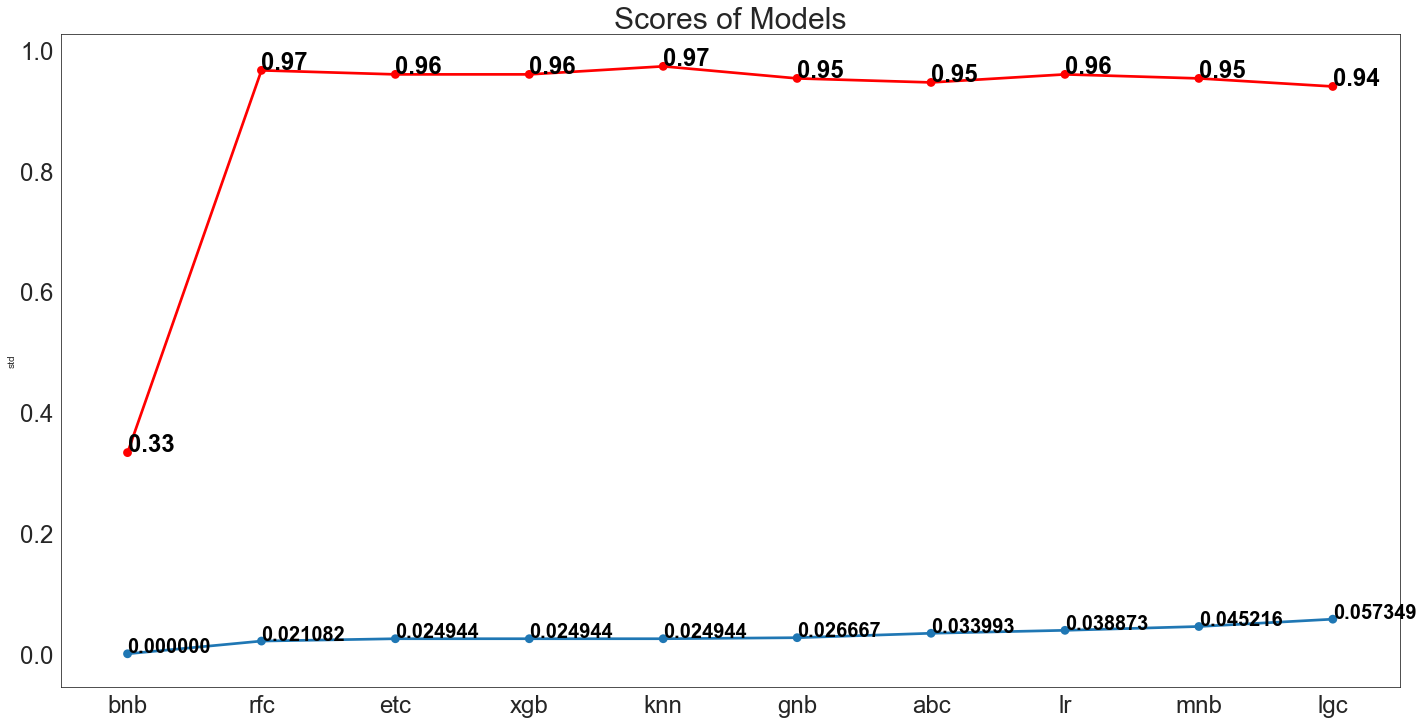

In [18]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax1 = sns.pointplot(x=df_algo.algo.tolist(), y=df_algo["mean"], markers=['o'], linestyles=['-'], color='red')
for i, score in enumerate(df_algo["mean"].tolist()):
    ax1.text(i, score + 0.002, '{:.2f}'.format(score), horizontalalignment='left', fontsize=24, color='black', weight='semibold')

ax2 = sns.pointplot(x=df_algo.algo.tolist(), y=df_algo["std"], markers=['o'], linestyles=['-'])
for i, score in enumerate(df_algo["std"].tolist()):
    ax2.text(i, score + 0.002, '{:.6f}'.format(score), horizontalalignment='left', fontsize=20, color='black', weight='semibold')


plt.title('Scores of Models', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

### As you can see Randomforest Classifier have 0.02494 standard deviation and 97% accuracy

### Create random Forest classifier

In [19]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

print(rfc.score(X_train, y_train), rfc.score(X_test, y_test))

1.0 0.9473684210526315


### Classification report

In [20]:
ypred = rfc.predict(X_test)
print(classification_report(y_test, ypred))
print("\n\n")
print(confusion_matrix(y_test, ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.92      0.92      0.92        13
           2       0.92      0.92      0.92        13

   micro avg       0.95      0.95      0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38




[[12  0  0]
 [ 0 12  1]
 [ 0  1 12]]


### Save model, scaler, and label encoder

In [21]:
# Save the Modle to file in the current working directory
model_filename = "./models/model.pkl"  
label_enc_filename = "./models/label_encoder.obj"
scaler_filename = "./models/scaler.obj"

with open(model_filename, 'wb') as file_model:  
    pickle.dump(rfc, file_model)
    
with open(label_enc_filename, 'wb') as file_enc:  
    pickle.dump(label_enc, file_enc)
    
with open(scaler_filename, 'wb') as file_scaler:  
    pickle.dump(scaler, file_scaler)

### Load model, scaler, and label encoder from file

In [22]:
# Load the Model back from file
with open(model_filename, 'rb') as file_model:  
    model = pickle.load(file_model)


# Load the Encoder back from file
with open(label_enc_filename, 'rb') as file_enc:  
    lblencoder = pickle.load(file_enc)

    
# Load the Scaler back from file
with open(scaler_filename, 'rb') as file_scaler:  
    scaler = pickle.load(file_scaler)

In [23]:
y_testpred = rfc.predict(X_test)

In [24]:
y_testpred

array([1, 0, 2, 1, 2, 1, 2, 2, 0, 0, 0, 0, 1, 0, 2, 2, 2, 0, 2, 1, 0, 1,
       1, 2, 2, 0, 1, 1, 0, 1, 1, 1, 2, 2, 2, 1, 0, 0])

In [26]:
print(classification_report(y_test, y_testpred))
print(confusion_matrix(y_test, y_testpred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.92      0.92      0.92        13
           2       0.92      0.92      0.92        13

   micro avg       0.95      0.95      0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38

[[12  0  0]
 [ 0 12  1]
 [ 0  1 12]]
